# MLS 3: brain_stroke-processing_job.ipynb

*This notebook will show you how to create a processing job, and with the help of that processing job, you can do all the data pre-processing steps*

*In this, we are providing, with the help of screenshots, what happens after running the processing job successfully*



### *Before running the below codes, you need to do some pre-requisite steps. Refer below to the steps along with screenshots:*

* Create a folder called my_package.

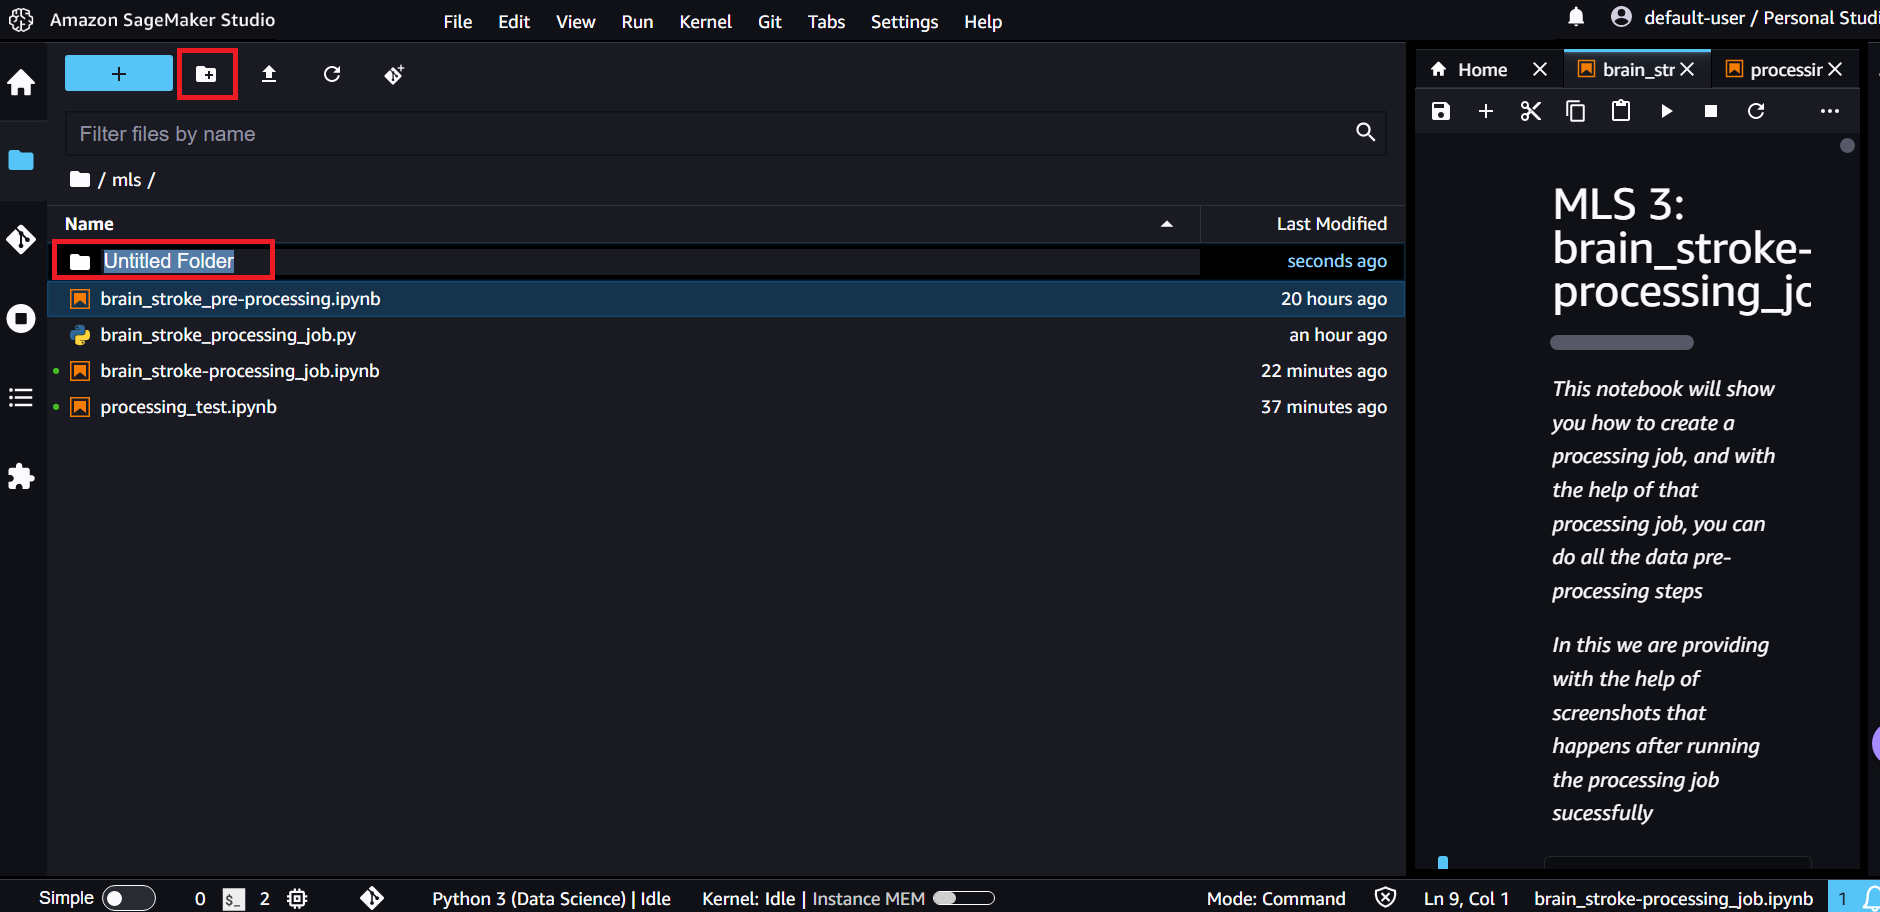

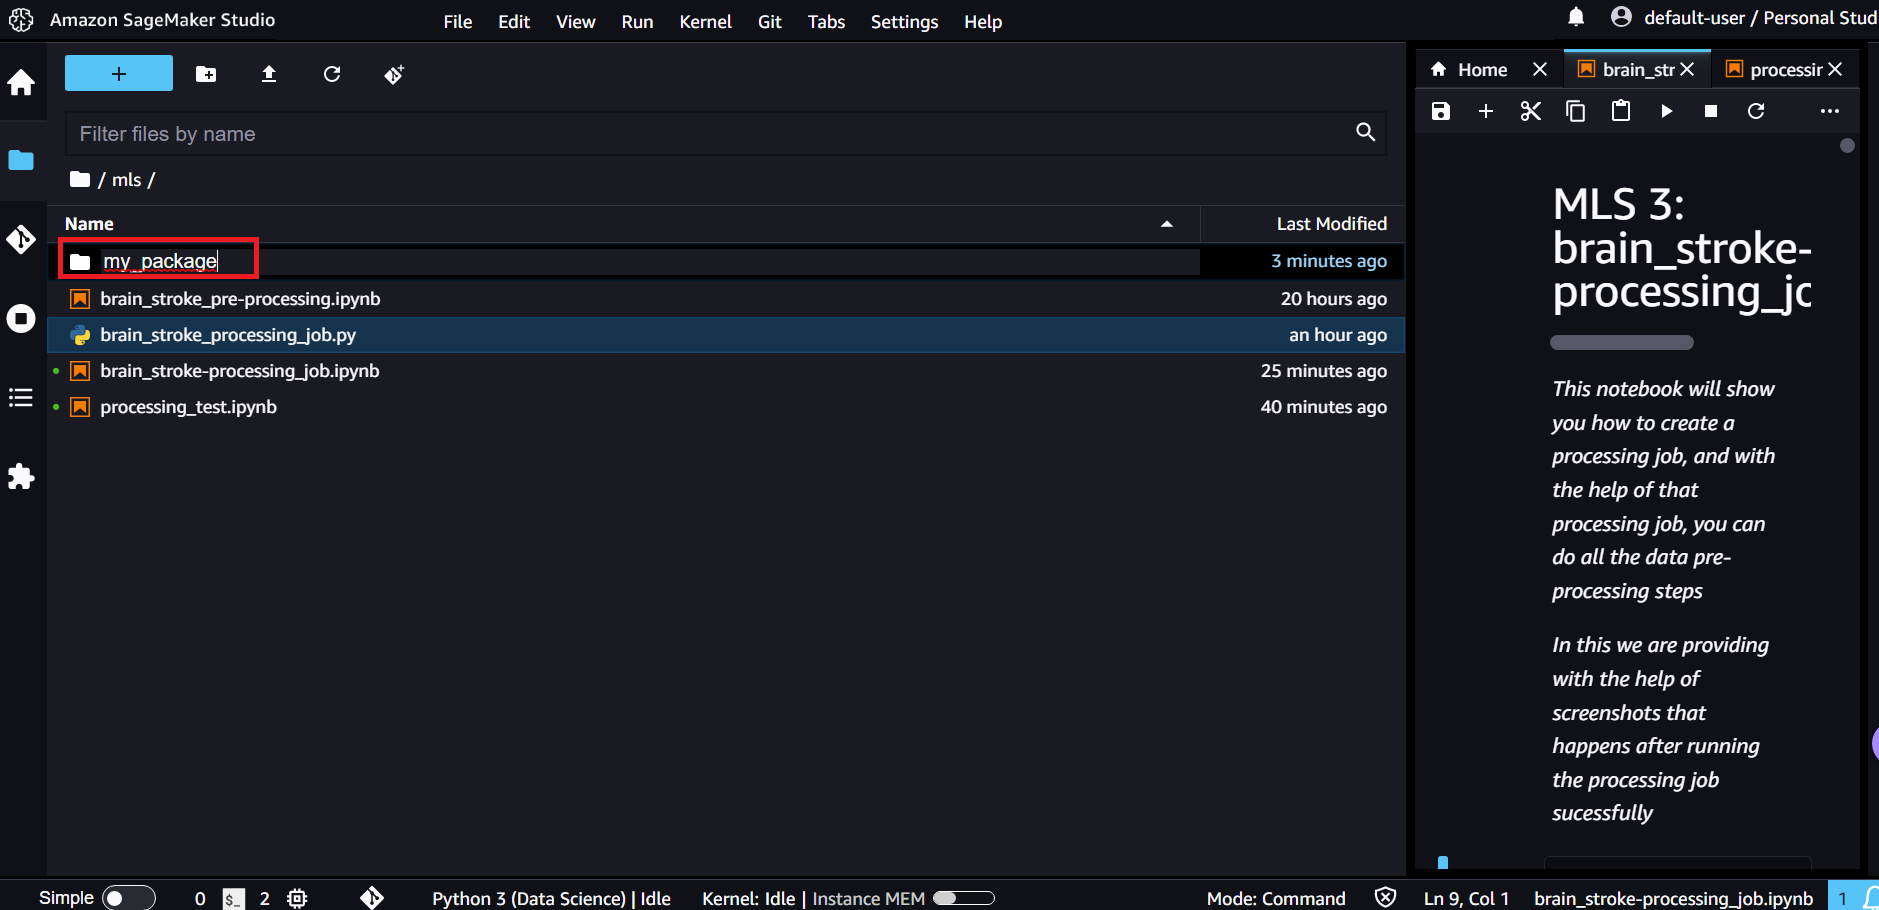


* After renaming the folder as my_package, upload the requirements.txt file and brain_stroke.csv file inside the my_package folder. 


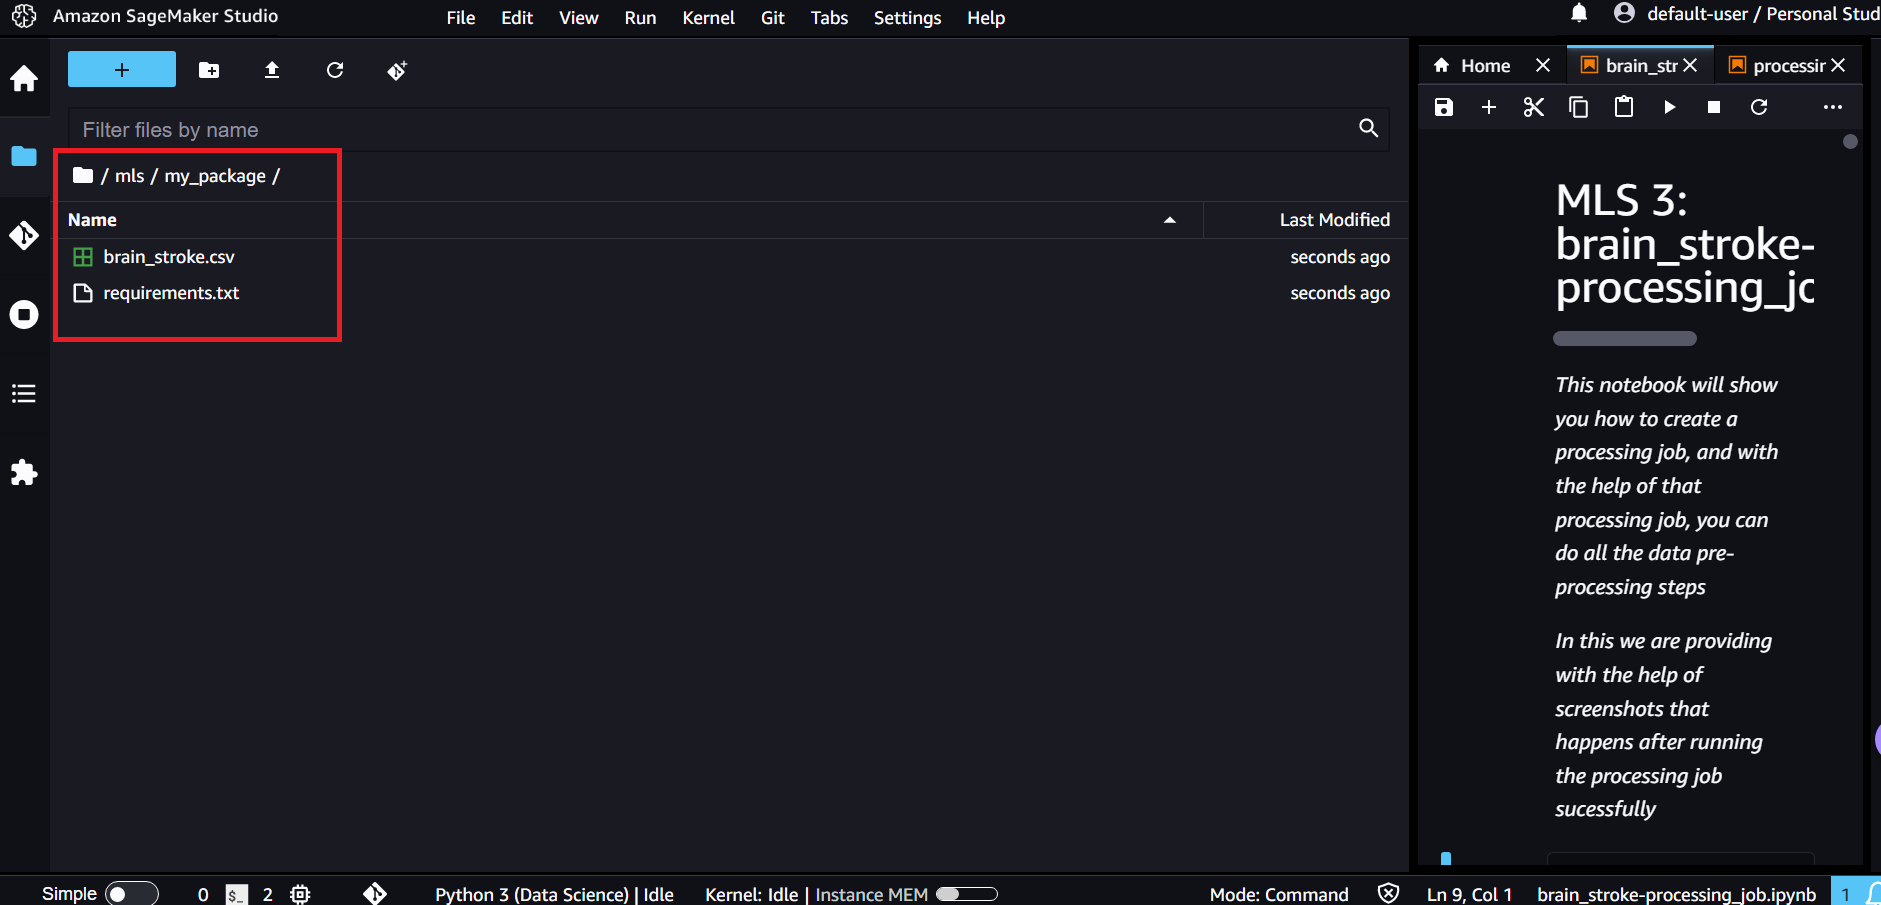

* Install Required Packages:
The first step of this code is to install all the necessary packages required for this processing job. The command os.system('pip install -r /opt/ml/processing/input/code/mls/my_package/requirements.txt') is used to install the required packages using pip.

* Import Required Packages:
After installing the required packages, the next step is to import them. Various packages are used to manipulate, preprocess, and write data into S3 bucket.

* Create an S3 Bucket:
The code then creates an S3 bucket to read and write data from it. It sets the bucket name and region variables and creates a bucket with that name in the specified region.

* Write Data to S3:
The next step is to write data to the S3 bucket. The data file is read and uploaded to S3 using the boto3 library.

* Data Preprocessing:
After the data is successfully uploaded to S3, the preprocessing of data begins. The first step is to handle missing values in the age column by imputing with the mean.

* Remove Rows with Unknown Smoking Status:
The rows with unknown smoking status are removed from the data set.

* Split the Vector into Two Parts:
The avg_glucose_level_bmi column in the data set is split into two columns avg_glucose_level and bmi. This is achieved using a lambda function.

* Rename the Residence Type Feature:
The Residence_type column is renamed to residence_type.

* Drop Duplicate Rows:
Duplicate rows are dropped, keeping only the first occurrence.

* Change Data Types:
The avg_glucose_level and bmi columns are converted to floating point values.

* Replace Special Characters:
The special characters "-" and "_" in the work_type column are replaced with spaces.

* Convert String Features to Lower Case:
All string features are converted to lower case.

* Encode Categorical Variables:
All categorical variables are encoded using the LabelEncoder.

* Balance Data:
The data is balanced using the SMOTE technique.

* Standardize Numeric Data:
The numeric data is standardized using the StandardScaler.

* Handle Outliers:
Outliers in the bmi column are handled by removing rows with a bmi value outside two standard deviations from the mean.

* Split Data and Write to S3:
The final step is to split the data into training and test sets and write them to the S3 bucket.

* Overall, this code is a data preprocessing job that performs various preprocessing tasks on the input data, including handling missing values, removing duplicate rows, handling outliers, and balancing the data, among other things. Finally, it splits the data into training and test sets and writes them to the S3 bucket. This preprocessed data can be further used for training a machine learning model *


* *In the below screenshot, you can see that we have defined a path to access the my_package folder and get all the files present in it. /opt/ml/processing/input/code/ is a common directory structure used in Amazon SageMaker Processing jobs. After /opt/ml/processing/input/code/, we have added mls/my_package/requirements.txt because, as you can see in the below screenshot, mls is a main folder, and inside it, I have created another folder called my_package, and the requirements.txt file is present in it*


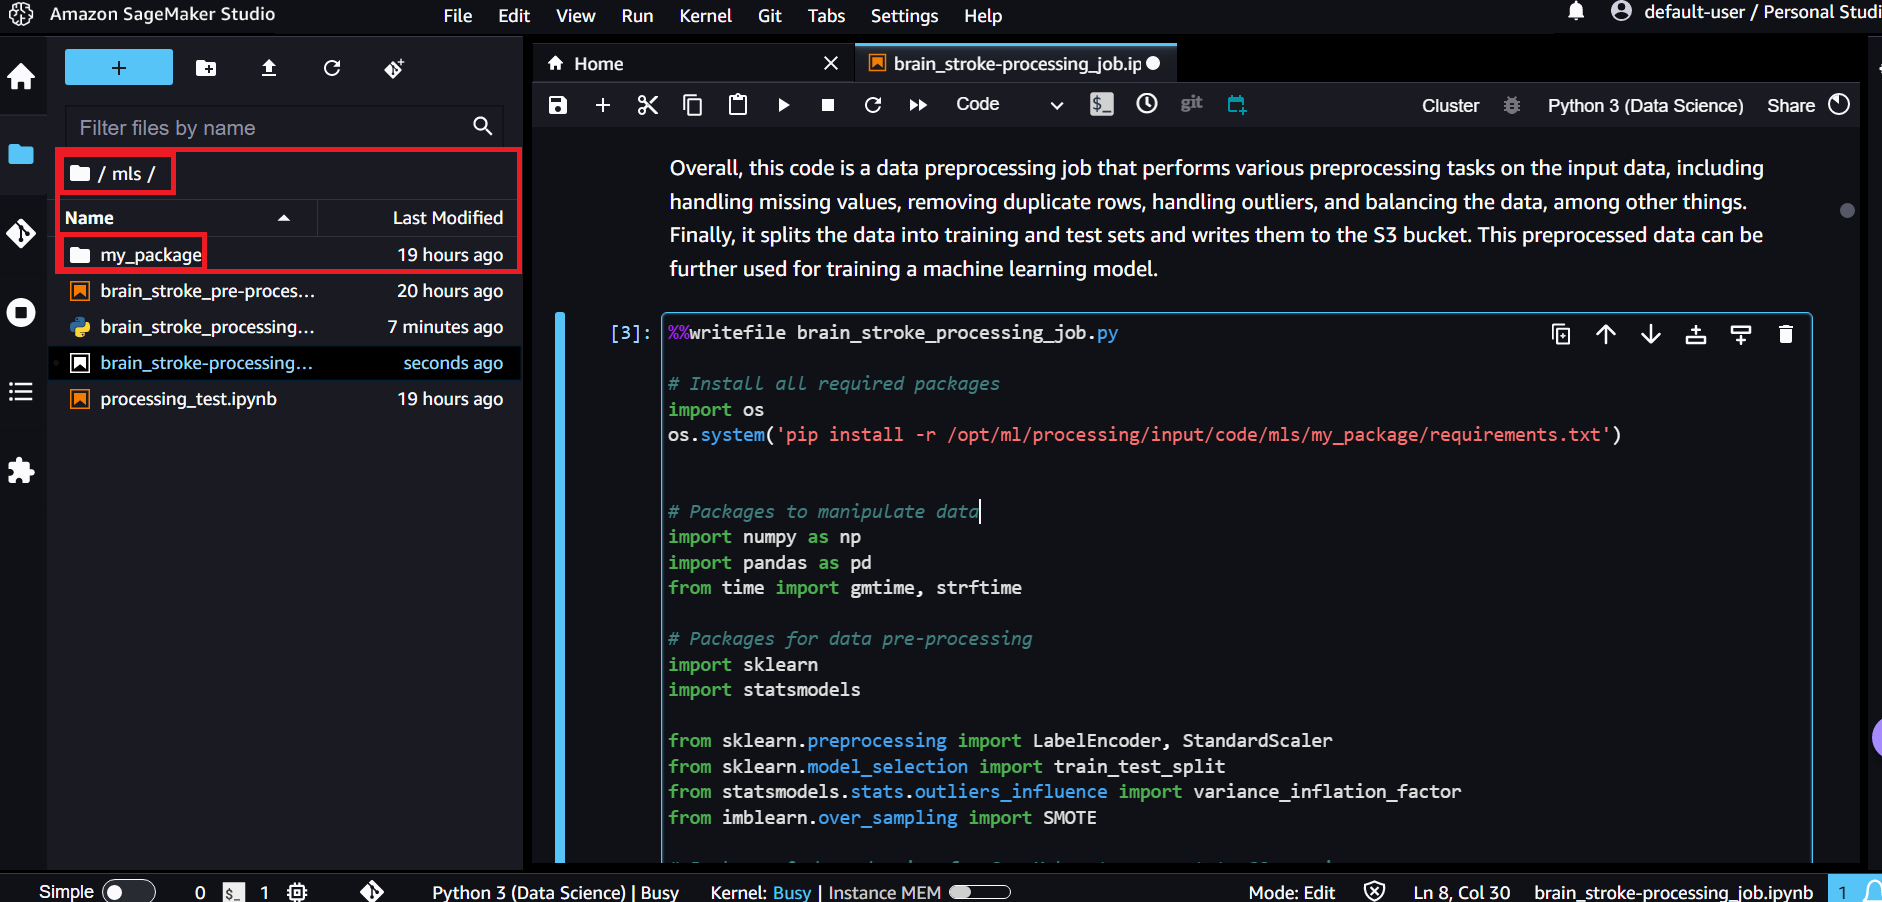

### Creating a data pre-processing python script

In [2]:
%%writefile brain_stroke_processing_job.py

# Install all required packages
import os
os.system('pip install -r /opt/ml/processing/input/code/mls-2-Data-Preprocessing/my_package/requirements.txt')


# Packages to manipulate data
import numpy as np
import pandas as pd
from time import gmtime, strftime

# Packages for data pre-processing
import sklearn
import statsmodels

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

# Packages & dependencies for SageMaker to connect to S3 service
import boto3, re, sys, math, json, os, sagemaker, s3fs

print('Imported all required packages')

# -------------------------------------------
# Create S3 bucket to read & write data from
# -------------------------------------------

# Set the bucket name and region variables: Change the bucket name with a unique name
bucket_name = 'bucket-demo-tn'
my_region = boto3.session.Session().region_name
print(my_region)

s3 = boto3.resource('s3')
#s3.create_bucket(Bucket=bucket_name)
s3_client = boto3.client("s3")

print('S3 bucket created successfully')
    
# Set variables to write data into s3
data = 'brain_stroke-2.csv'
prefix = 'pre-processing'

# Write the data into s3
boto3.Session().resource('s3').Bucket(bucket_name) \
     .Object(os.path.join(prefix, 'input/brain_stroke-2.csv')) \
     .upload_file('/opt/ml/processing/input/code/mls-2-Data-Preprocessing/my_package/brain_stroke-2.csv')

# -------------------------------------------
# Data Pre-processing
# -------------------------------------------

# Read data into pandas dataframe
df = pd.read_csv(s3_client.get_object(Bucket=bucket_name, Key='pre-processing/input/brain_stroke-2.csv').get("Body"))
df.head()

# Handle missing values in age by imputing with mean
df['age'].fillna(df['age'].mean(), inplace = True)

# Remove rows with "Unknown" smoking status
df = df[df['smoking_status']!='Unknown']

# Apply lamba function to split the vector into 2 parts
df['avg_glucose_level'] = df['avg_glucose_level_bmi'].apply(lambda x:x.split(';')[0])
df['bmi'] = df['avg_glucose_level_bmi'].apply(lambda x:x.split(';')[1])

# Drop the vector column
df.drop('avg_glucose_level_bmi', inplace = True, axis = 1)

# Rename Residence Type feature - standardize to snake_case
df.rename(columns = {'Residence_type':'residence_type'}, inplace=True)

# Drop duplicate rows
df.drop_duplicates(keep = 'first', inplace = True)

# Change avg_glucose_level and bmi to floating point values
df['avg_glucose_level'] = df['avg_glucose_level'].astype('float')
df['bmi'] = df['bmi'].astype('float')

# Use RegEx to replace '-' and '_' to ' '
df['work_type'] = df['work_type'].str.replace(r'[-_]', ' ', regex=True).astype('str')

# Convert all string features to lower case
df['gender'] = df['gender'].str.lower()
df['ever_married'] = df['ever_married'].str.lower()
df['work_type'] = df['work_type'].str.lower()
df['residence_type'] = df['residence_type'].str.lower()
df['smoking_status'] = df['smoking_status'].str.lower()

# Encode all categorical variables
encd_df = df.apply(LabelEncoder().fit_transform)

# Balance data
oversample = SMOTE(random_state = 2, sampling_strategy='auto')
xo = encd_df.loc[:, encd_df.columns != 'stroke']
yo = encd_df.loc[:, 'stroke']
x = xo.values
y = yo.values
x, y = oversample.fit_resample(x, y)
x = pd.DataFrame(x, columns = xo.columns)
y = pd.DataFrame(y, columns=['stroke'])
sm_df = pd.concat([x, y], axis = 1)

# Standardize Numeric Data
sc = StandardScaler()
sm_df[['age', 'avg_glucose_level','bmi']] = sc.fit_transform(sm_df[['age', 'avg_glucose_level','bmi']])

# Handle Outliers
upper_limit = sm_df['bmi'].mean() + (2*sm_df['bmi'].std())
lower_limit = sm_df['bmi'].mean() - (2*sm_df['bmi'].std())
sm_df = sm_df[(sm_df['bmi'] <= upper_limit) & (sm_df['bmi'] >= lower_limit)]

# -------------------------------------------
# Split Data and Write to S3
# -------------------------------------------

# Split data
x = sm_df.loc[:, sm_df.columns != 'stroke']
y = sm_df.loc[:, 'stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)
x_train.shape

# Write to S3
x_train.to_csv('x_train.csv', index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'output/split_data/x_train.csv')).upload_file('x_train.csv')

x_test.to_csv('x_test.csv', index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'output/split_data/x_test.csv')).upload_file('x_test.csv')

y_train.to_csv('y_train.csv', index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'output/split_data/y_train.csv')).upload_file('y_train.csv')

y_test.to_csv('y_test.csv', index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'output/split_data/y_test.csv')).upload_file('y_test.csv')

# End
print("data pre-processing complete")

Overwriting brain_stroke_processing_job.py


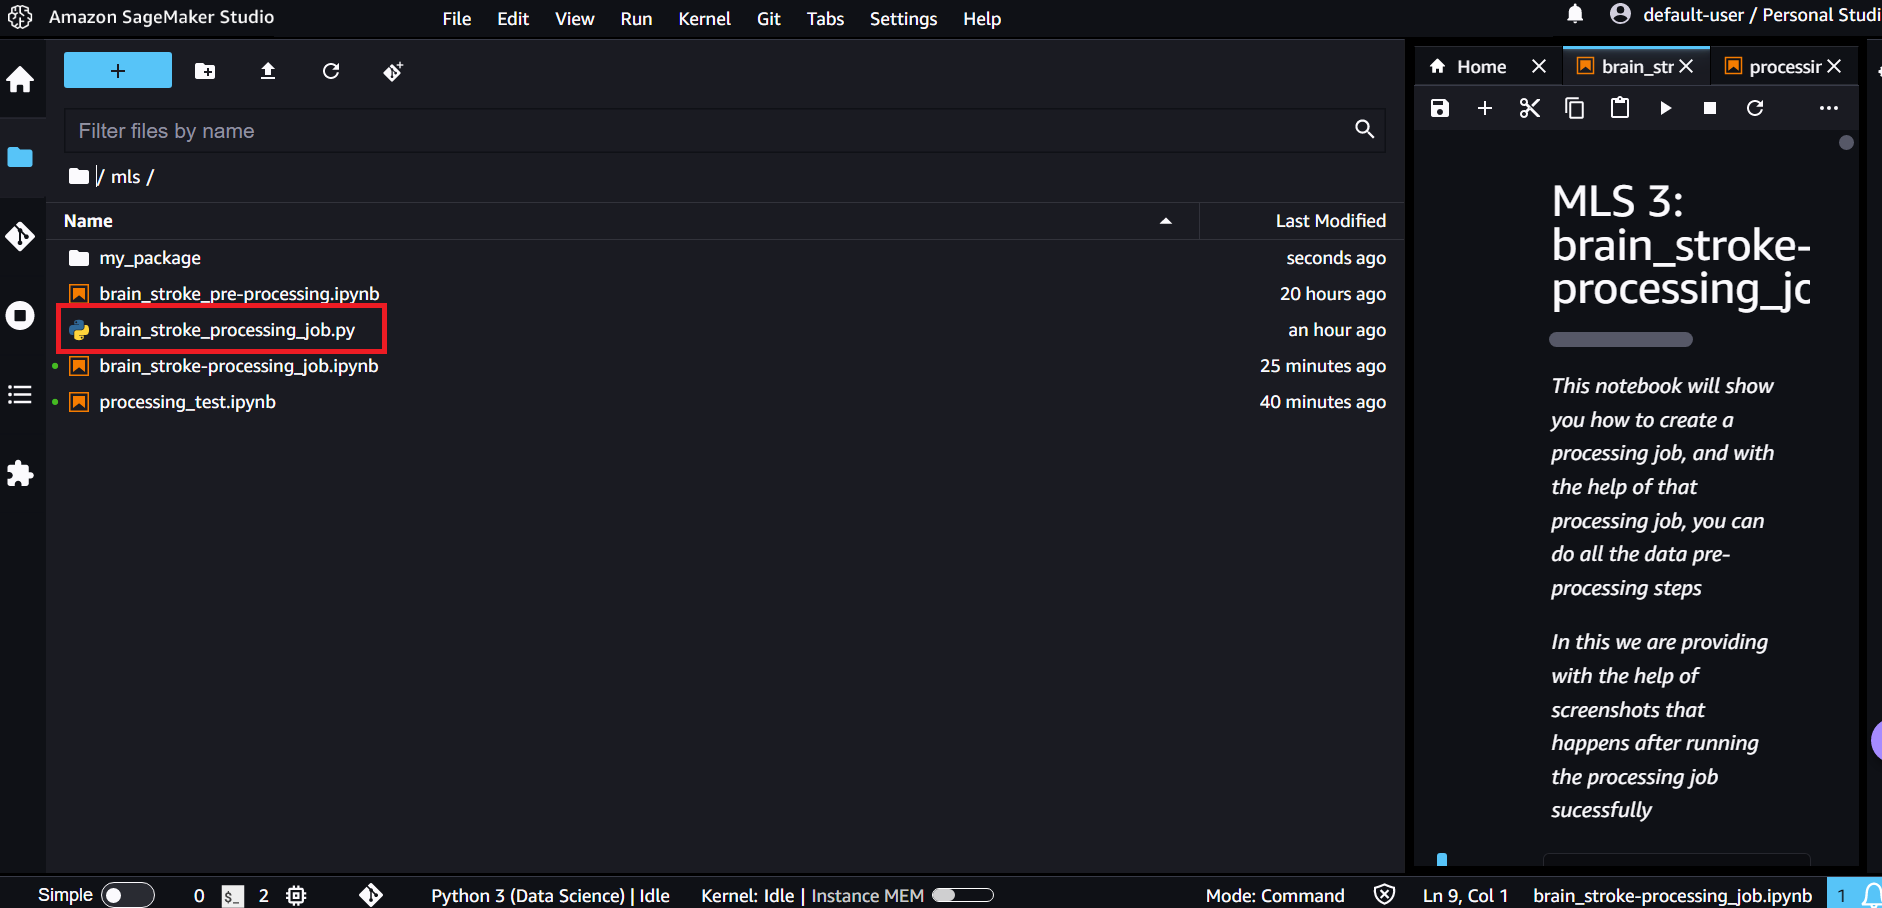

### Importing the necessary packages needed for running a processing job

In [3]:
# Packages needed for running a processing job
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# Get region and role
region = boto3.session.Session().region_name
role = get_execution_role()

### Setting up the parameters

In [5]:
# Set the parameters for the processing job
sklearn_processor = SKLearnProcessor(
    framework_version="1.2-1", # stable version
    role=role, # Default IAM role
    instance_type="ml.t3.medium", # EC2 instance
    instance_count=1, # Number of Instances
    volume_size_in_gb=1 # Storage space
)

### Running a processing job

In [6]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput

sklearn_processor.run(
    code="brain_stroke_processing_job.py",
    inputs=[ProcessingInput(source='my_package/', destination="/opt/ml/processing/input/code/mls-2-Data-Preprocessing/my_package/")]
)

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-06-08-22-13-38-390


.................................................................................Requirement already satisfied: numpy in /miniconda3/lib/python3.8/site-packages (from -r /opt/ml/processing/input/code/mls-2-Data-Preprocessing/my_package/requirements.txt (line 1)) (1.24.1)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warni

After running the processing job

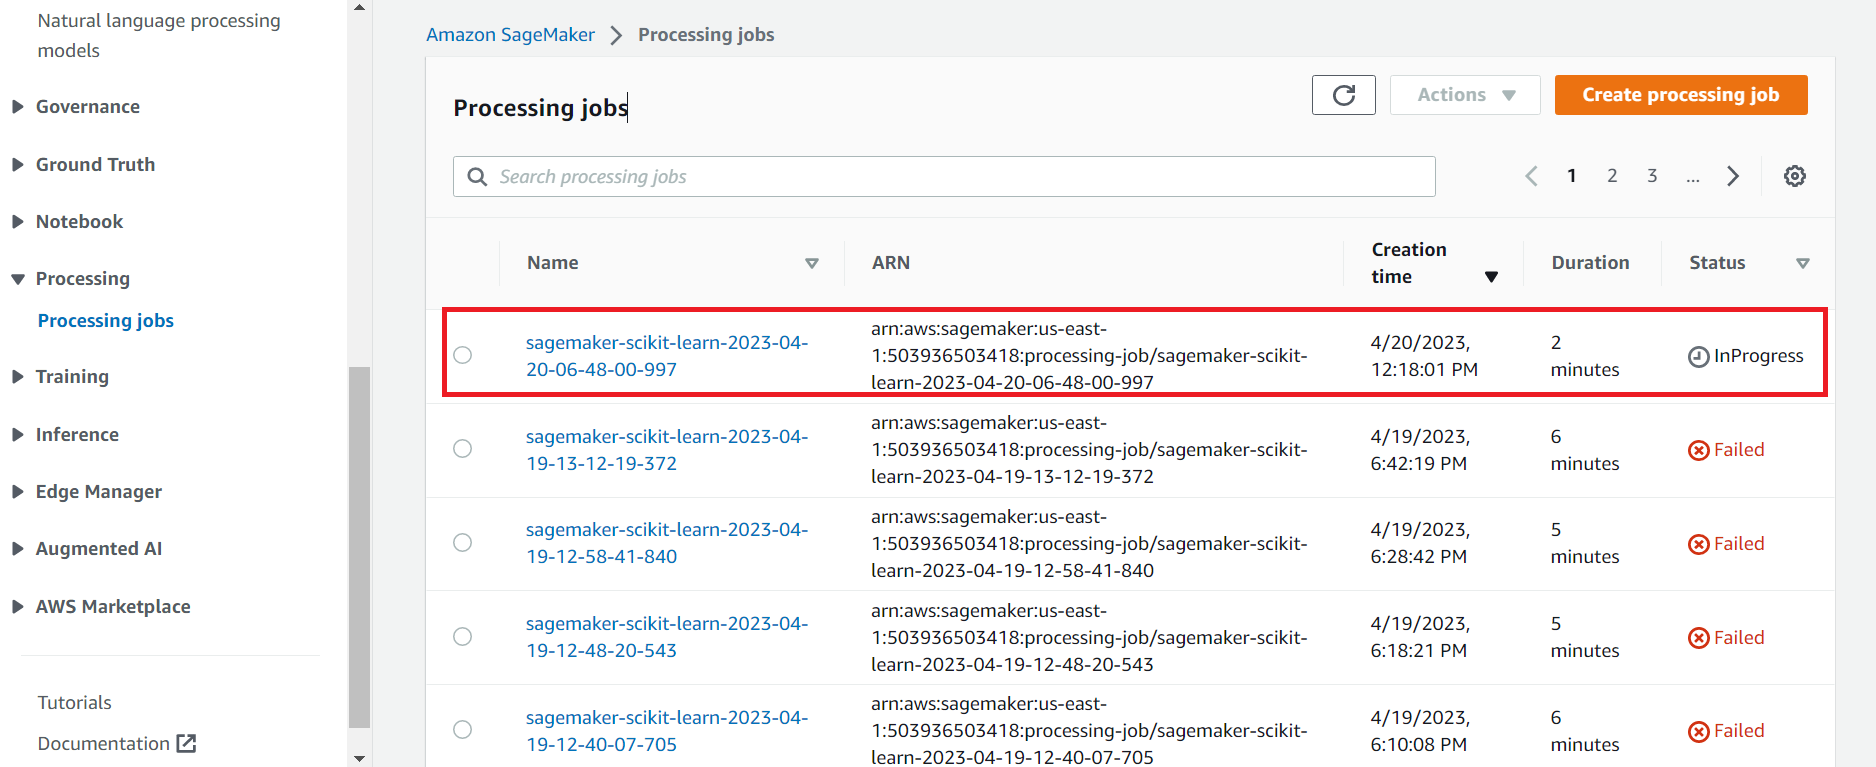

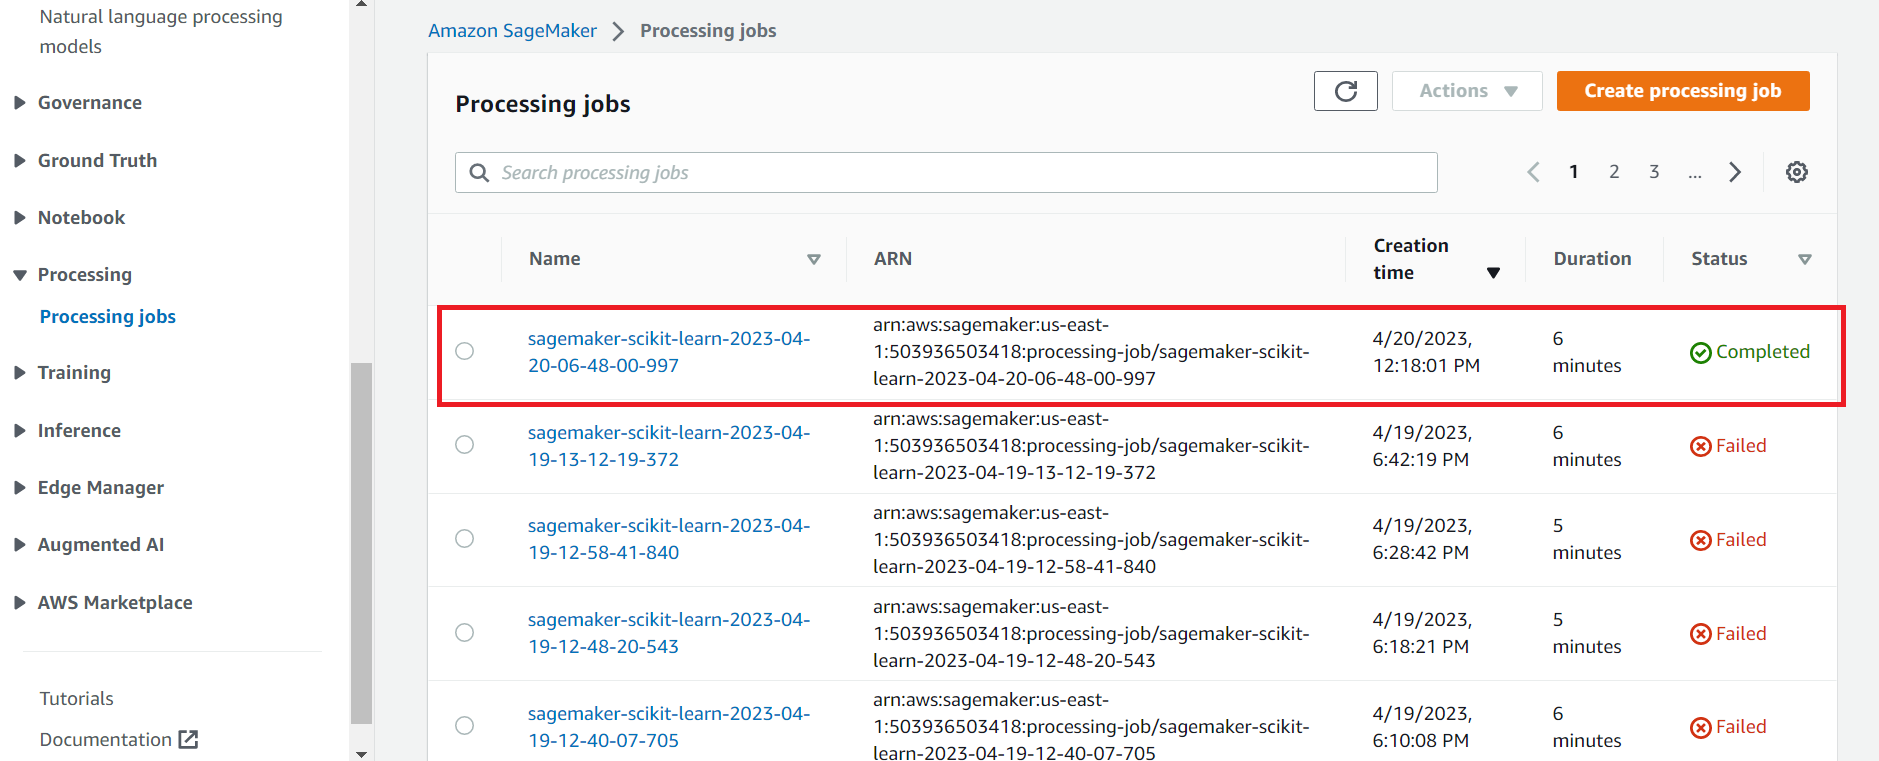

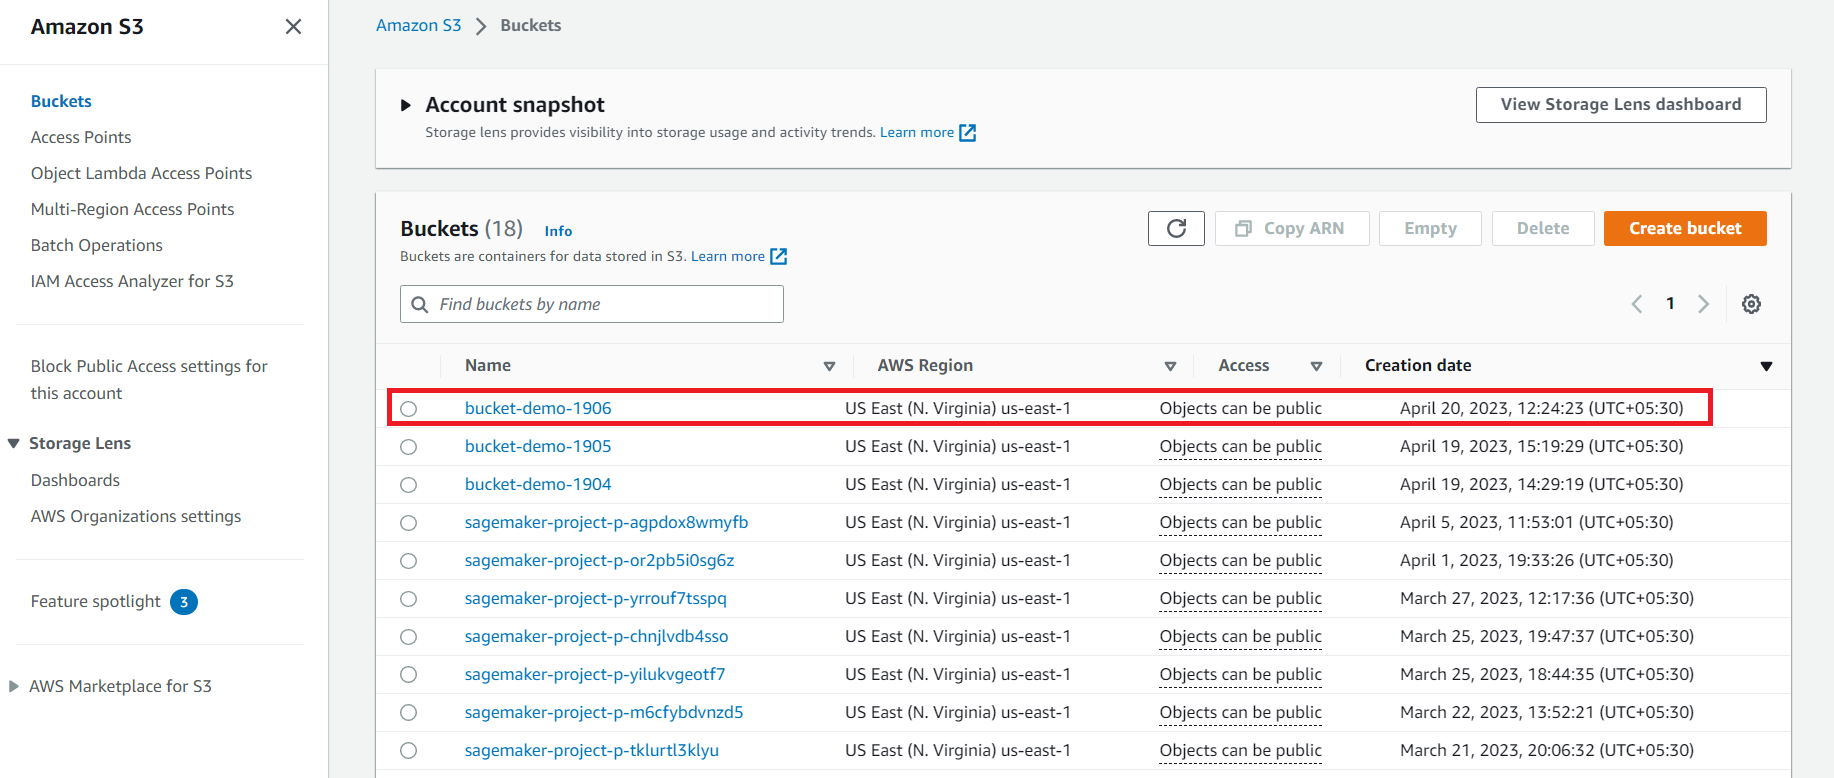

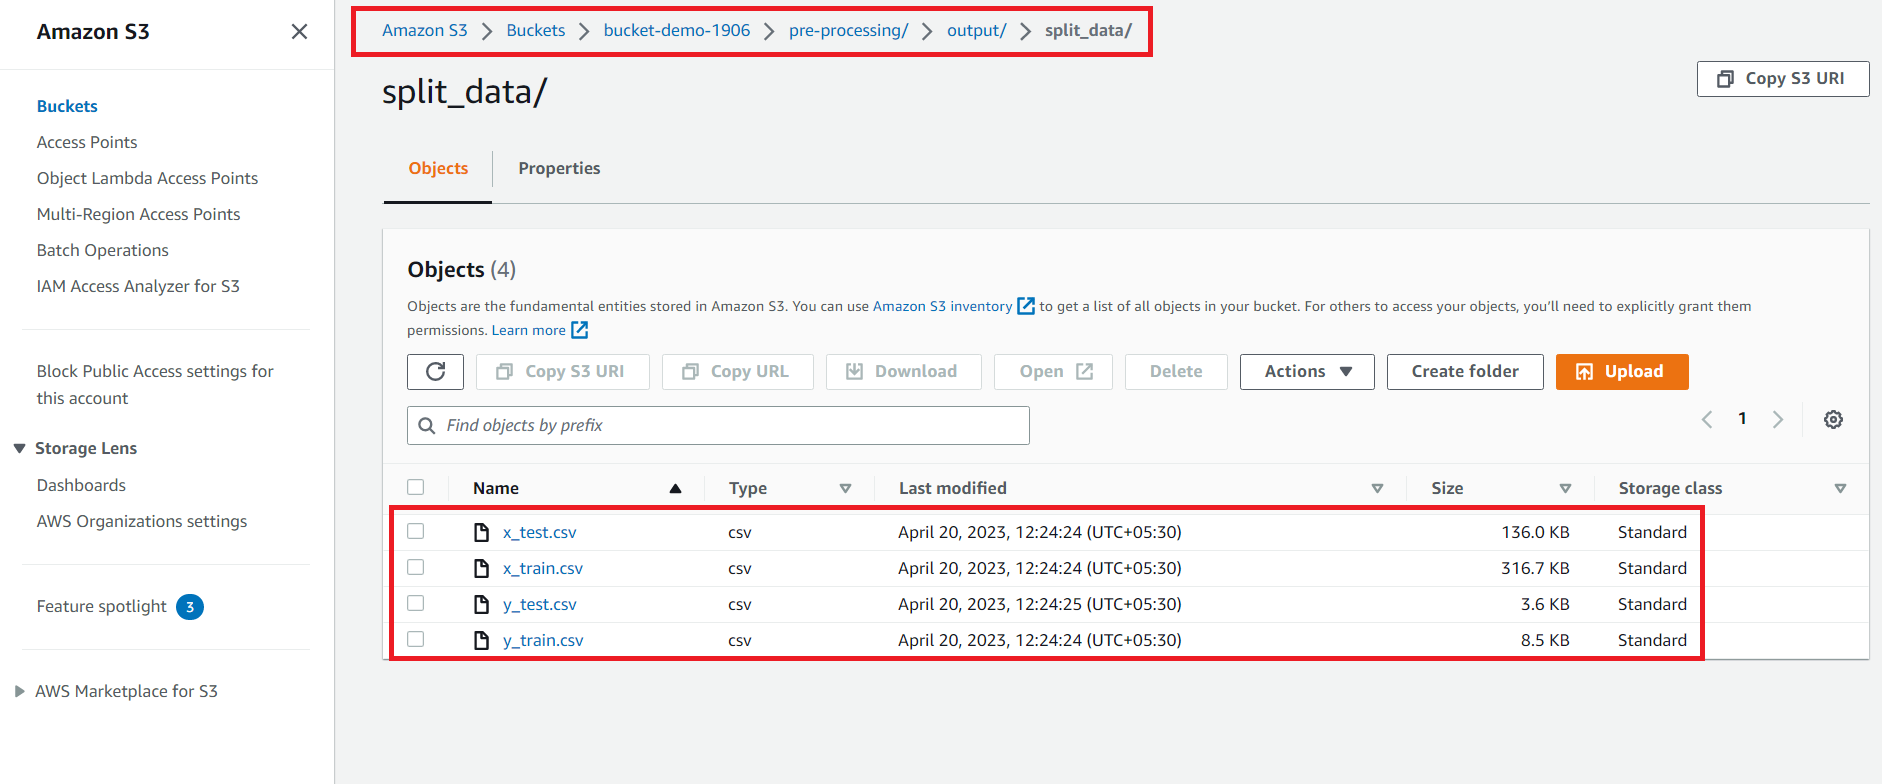

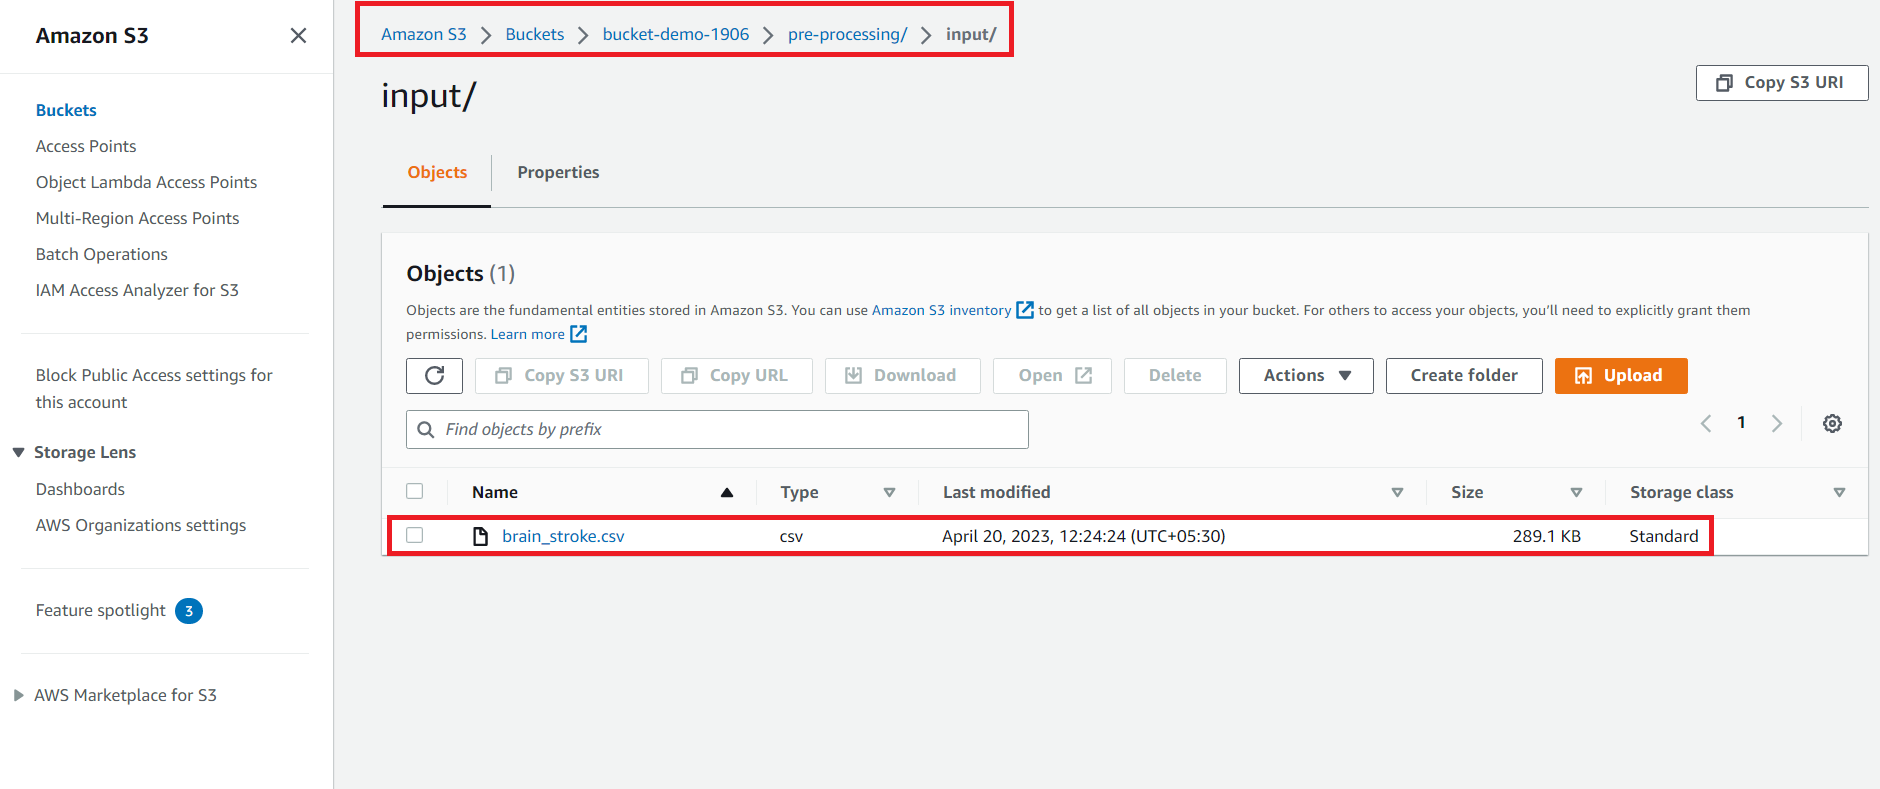